## Credit Card Prediction Model

In [ ]:
# Importing modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import itertools
import shap
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve, 
    fbeta_score
)

In [4]:
# Load dataset
df = pd.read_csv("train.csv")
print("Train shape:", df.shape)
df.head()

Train shape: (25247, 27)


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


#### Dataset Preprocessing and Cleaning

In [5]:
# Defining some frequently used columns

pay_status_cols = ['pay_0']+[f'pay_{i}' for i in range(2,7)]
cat_cols = ['sex', 'education', 'marriage']
bill_cols = [f'bill_amt{i}' for i in range(1,7)]
pay_amt_cols = [f'pay_amt{i}' for i in range(1,7)]
numeric_cols = ['limit_bal','age',*bill_cols,*pay_amt_cols,*pay_status_cols]

In [6]:
# Preprocessing the data 

def preprocess(dataset):
    print("\nMissing values:")
    print(dataset.isnull().sum()[dataset.isnull().sum() > 0])

    dataset.columns = [col.strip().lower() for col in dataset.columns]
    if 'next_month_default' in dataset.columns:
        dataset = dataset.dropna(subset=['next_month_default'])
            
    if dataset.duplicated().sum() > 0:
        dataset = dataset.drop_duplicates().reset_index(drop=True)
        print("Dropped duplicates. New shape:", dataset.shape)

    for col in cat_cols:
        dataset[col] = dataset[col].astype('category')

    for col in numeric_cols:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

    for col in numeric_cols:
        if col in dataset.columns:
            dataset[col].fillna(dataset[col].median(), inplace=True)

    for col in cat_cols:
        if col in dataset.columns:
            dataset[col].fillna(dataset[col].mode()[0], inplace=True)
    if 'next_month_default' in dataset.columns:
        dataset['next_month_default'] = dataset['next_month_default'].astype(int)
    print("Final dataset shape:", dataset.shape)
    dataset.head()
    return dataset

df = preprocess(df.copy())


Missing values:
age    126
dtype: int64
Final dataset shape: (25247, 27)


#### Feature Engineering

In [7]:
# Feature Engg
def feature_engg(ds):
    ds['total_bill'] = ds[bill_cols].sum(axis=1)
    ds['utilization'] = ds['total_bill'] / ds['limit_bal'].replace(0, 1)
    ds['total_pay'] = ds[pay_amt_cols].sum(axis=1)
    ds['pay_to_bill_ratio'] = ds['total_pay'] / ds['total_bill'].replace(0, 1)
    ds['avg_bill'] = ds[bill_cols].mean(axis=1)
    ds['utilization_trend'] = (ds['bill_amt1'] - ds['bill_amt6']) / ds['limit_bal']
    ds['repay_ratio'] = ds[pay_amt_cols].mean(axis=1) / (ds[bill_cols].mean(axis=1) + 1e-5)
    ds['balance_change'] = (ds['bill_amt1'] - ds['bill_amt6']) / 6
    ds['payment_consistency'] = (ds[pay_amt_cols].std(axis=1) / (ds[pay_amt_cols].mean(axis=1) + 1e-5))
    ds['avg_delay'] = ds[pay_status_cols].apply(lambda row: row[row > 0].mean() if (row > 0).any() else 0,axis=1)
    
    def longest_delinquency(row):
        runs = (len(list(g)) for k, g in itertools.groupby(row > 0) if k)
        return max(runs, default=0)
    
    ds['delinquency_streak'] = [
        longest_delinquency(ds.loc[i, pay_status_cols].values)
        for i in ds.index
    ]

    def repayment_consistency(row):
        return (row <= 0).sum() / len(row)
    ds['repay_consistency'] = ds[pay_status_cols].apply(repayment_consistency, axis=1)
    ds['months_overdue_count'] = ds[pay_status_cols].gt(0).sum(axis=1)

    ds['recent_delay_0'] = (ds['pay_0'] > 0).astype(int)
    ds['recent_delay_1'] = (ds['pay_2'] > 0).astype(int)
    return ds

df = feature_engg(df.copy())

engineered_cols = [
    'total_bill', 'utilization',
    'total_pay', 'pay_to_bill_ratio',
    'avg_bill', 'delinquency_streak',
    'repay_consistency', 'months_overdue_count',
    'recent_delay_0', 'recent_delay_1'
]

df[engineered_cols + ['next_month_default']].head(10)


,total_bill,utilization,total_pay,pay_to_bill_ratio,avg_bill,delinquency_streak,repay_consistency,months_overdue_count,recent_delay_0,recent_delay_1,next_month_default
0,249068.99,4.151150,7957.11,0.031947,41511.498333,3,0.500000,3,1,1,0
1,15210.46,0.052450,4049.99,0.266263,2535.076667,0,1.000000,0,0,0,0
2,302530.10,1.680723,12055.72,0.039850,50421.683333,0,1.000000,0,0,0,0
3,517378.53,2.463707,18449.50,0.035660,86229.755000,0,1.000000,0,0,0,0
4,70885.52,0.253163,51314.20,0.723902,11814.253333,0,1.000000,0,0,0,0
5,11677.89,0.145974,9657.95,0.827029,1946.315000,1,0.833333,1,0,1,0
6,91114.22,0.455571,74218.61,0.814567,15185.703333,0,1.000000,0,0,0,0
7,126332.19,2.526644,15472.61,0.122476,21055.365000,0,1.000000,0,0,0,0
8,210239.88,4.204798,16398.86,0.078001,35039.980000,0,1.000000,0,0,0,0
9,57415.26,0.130489,20910.82,0.364203,9569.210000,0,1.000000,0,0,0,0


#### Exploratory Data Analysis

/tmp/ipykernel_106844/3538612405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="next_month_default", data=df, palette="Set2")


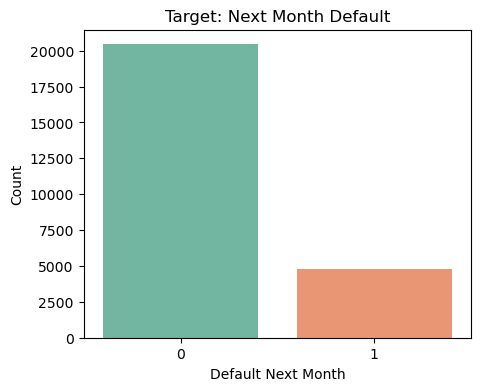

next_month_default
0    20440
1     4807
Name: count, dtype: int64
Default rate: 19.04%


In [8]:
# Visualizes the class distribution of the target variable and computes the overall default rate.
plt.figure(figsize=(5,4))
sns.countplot(x="next_month_default", data=df, palette="Set2")
plt.title("Target: Next Month Default")
plt.xlabel("Default Next Month")
plt.ylabel("Count")
plt.show()
print(df['next_month_default'].value_counts())
default_rate = df['next_month_default'].mean()
print(f"Default rate: {default_rate:.2%}")


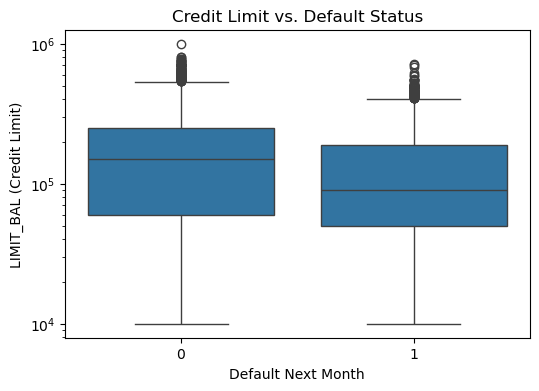

In [9]:
# Visualize the distribution of credit limit by default status using a log-scaled boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x='next_month_default', y='limit_bal', data=df)
plt.title("Credit Limit vs. Default Status")
plt.xlabel("Default Next Month")
plt.ylabel("LIMIT_BAL (Credit Limit)")
plt.yscale('log')
plt.show()

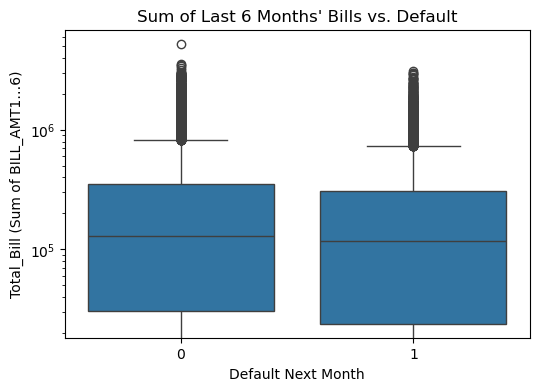

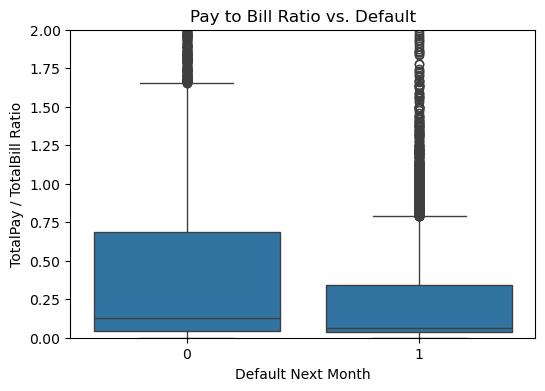

In [10]:
# Box plot of total bill amounts (log scale) to compare spending patterns by default status
plt.figure(figsize=(6,4))
sns.boxplot(x='next_month_default', y='total_bill', data=df)
plt.title("Sum of Last 6 Months' Bills vs. Default")
plt.xlabel("Default Next Month")
plt.ylabel("Total_Bill (Sum of BILL_AMT1…6)")
plt.yscale('log')
plt.show()

# Box plot of pay-to-bill ratio to assess payment behavior differences between defaulters and non-defaulters
plt.figure(figsize=(6,4))
sns.boxplot(x='next_month_default', y='pay_to_bill_ratio', data=df)
plt.title("Pay to Bill Ratio vs. Default")
plt.xlabel("Default Next Month")
plt.ylabel("TotalPay / TotalBill Ratio")
plt.ylim(0, 2)
plt.show()

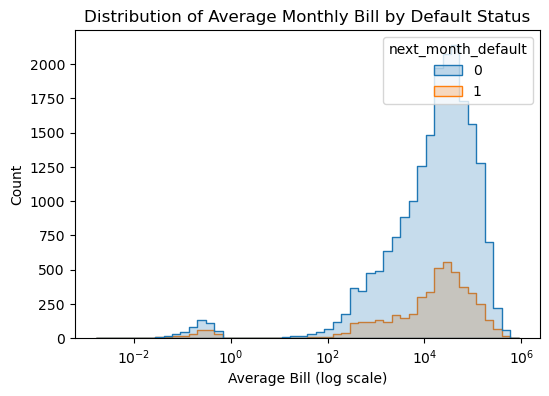

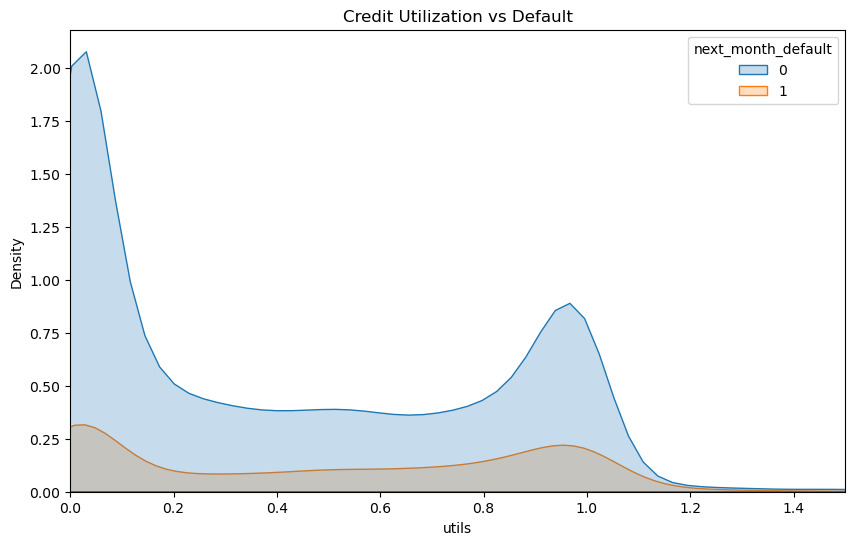

In [11]:
# Histogram of average monthly bill amounts by default status (log-scaled) to observe spending distribution
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='avg_bill', hue='next_month_default', 
             bins=50, kde=False, element='step', log_scale=True)
plt.title("Distribution of Average Monthly Bill by Default Status")
plt.xlabel("Average Bill (log scale)")
plt.show()

# KDE plot of credit utilization (bill to limit ratio) by default status to analyze usage behavior
df['utils'] = df['bill_amt1'] / df['limit_bal']
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x='utils', hue='next_month_default', fill=True)
plt.title('Credit Utilization vs Default')
plt.xlim(0, 1.5)
plt.show()
df.drop(['utils'],inplace=True,axis=1)

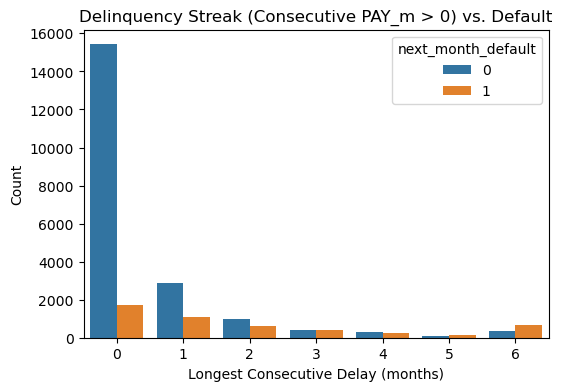

In [12]:
# Count plot showing the relationship between longest delinquency streak and default status
plt.figure(figsize=(6,4))
sns.countplot(x='delinquency_streak', hue='next_month_default', data=df,
              order=sorted(df['delinquency_streak'].unique()))
plt.title("Delinquency Streak (Consecutive PAY_m > 0) vs. Default")
plt.xlabel("Longest Consecutive Delay (months)")
plt.ylabel("Count")
plt.show()

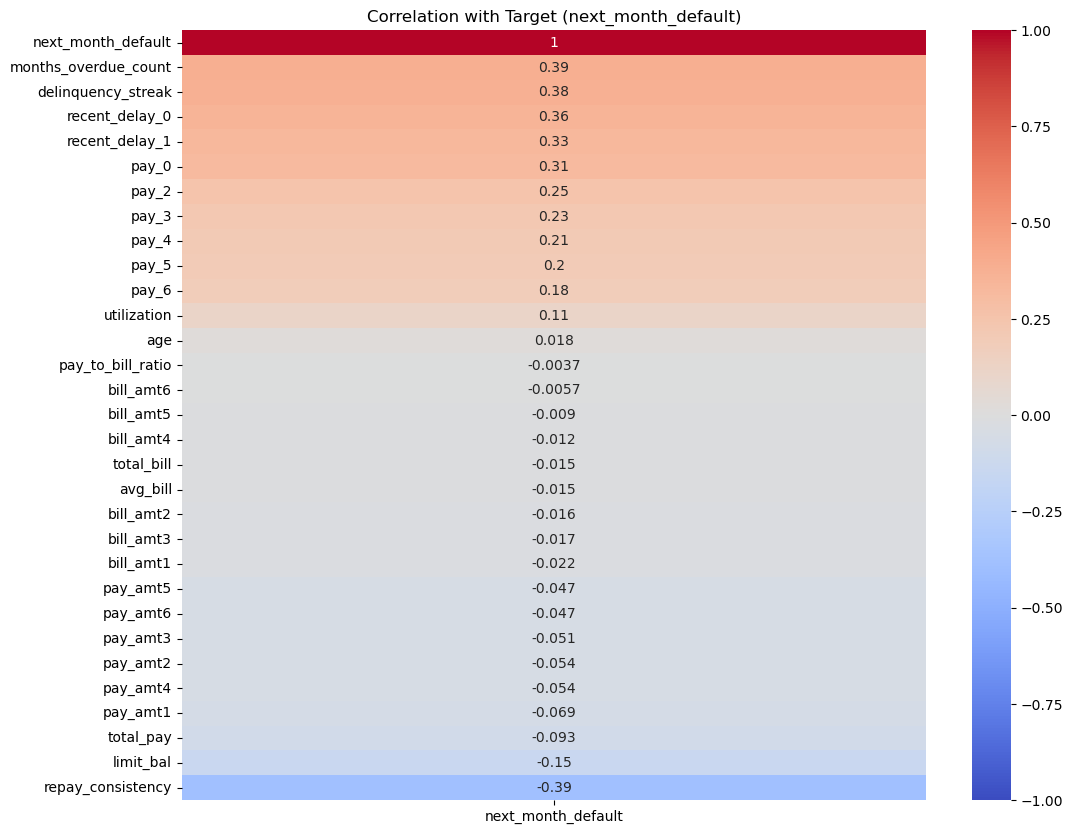

In [13]:
# Heatmap of feature correlations with the target variable to identify strongest predictors of default
corr = df[engineered_cols + ['next_month_default'] + numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr[['next_month_default']].sort_values(by='next_month_default', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Target (next_month_default)")
plt.show()

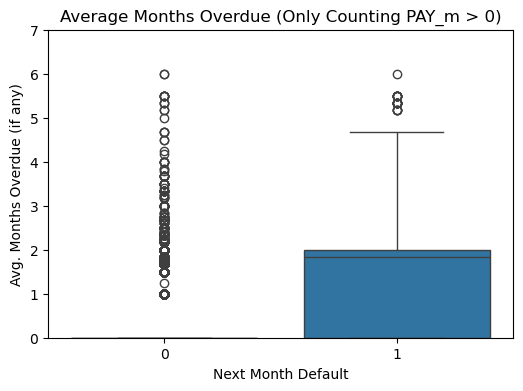

In [14]:
# Box plot showing average months overdue (for delays only) by default status to assess late payment behavior
plt.figure(figsize=(6,4))
sns.boxplot(x='next_month_default', y='avg_delay', data=df)
plt.ylim(0, 7)
plt.title("Average Months Overdue (Only Counting PAY_m > 0)")
plt.xlabel("Next Month Default")
plt.ylabel("Avg. Months Overdue (if any)")
plt.show()

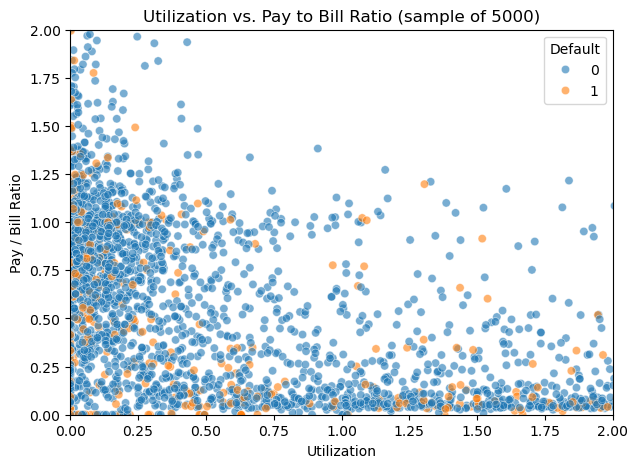

In [15]:
# Scatter plot of utilization vs. pay-to-bill ratio (sampled) to visualize separation between defaulters and non-defaulters

plt.figure(figsize=(7,5))
sns.scatterplot(
    x='utilization',
    y='pay_to_bill_ratio',
    hue='next_month_default',
    data=df.sample(5000, random_state=47),
    alpha=0.6
)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title("Utilization vs. Pay to Bill Ratio (sample of 5000)")
plt.xlabel("Utilization")
plt.ylabel("Pay / Bill Ratio")
plt.legend(title="Default")
plt.show()


segment
High Util & Low Consistency     0.500000
Low Util & Low Consistency      0.394309
Low Util & High Consistency     0.143314
High Util & High Consistency    0.117182
Name: next_month_default, dtype: float64


/tmp/ipykernel_106844/2495591105.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seg_rates.index, y=seg_rates.values, palette='Greens')


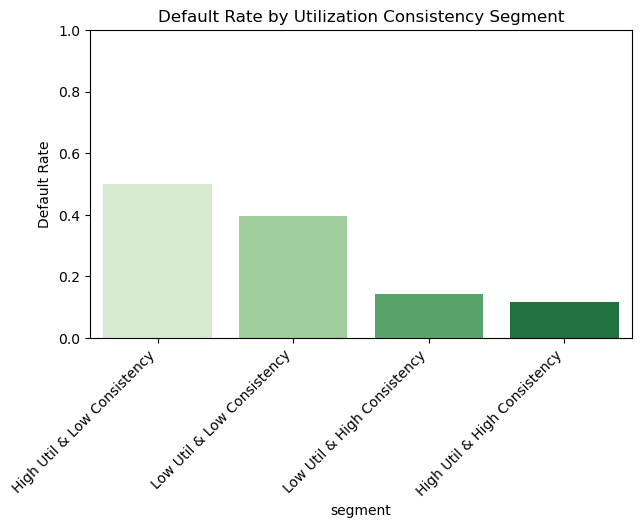

In [16]:
# Segment users based on utilization and repayment consistency, then visualize default rates across segments

df['high_util'] = (df['utilization'] > 0.5).astype(int)
df['low_consistency'] = (df['repay_consistency'] < 0.8).astype(int)

def segment_label(row):
    if row['high_util'] and row['low_consistency']:
        return 'High Util & Low Consistency'
    elif row['high_util'] and not row['low_consistency']:
        return 'High Util & High Consistency'
    elif not row['high_util'] and row['low_consistency']:
        return 'Low Util & Low Consistency'
    else:
        return 'Low Util & High Consistency'

df['segment'] = df.apply(segment_label, axis=1)
seg_rates = df.groupby('segment')['next_month_default'].mean().sort_values(ascending=False)
print(seg_rates)

plt.figure(figsize=(7,4))
sns.barplot(x=seg_rates.index, y=seg_rates.values, palette='Greens')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Default Rate")
plt.title("Default Rate by Utilization Consistency Segment")
plt.ylim(0, 1)
plt.show()
df.drop(['high_util','low_consistency','segment'],axis=1,inplace=True)


#### SMOTE

In [17]:
# Prepare feature matrix X and target y by dropping irrelevant columns and display data shape and class distribution

X = df.drop(['marriage', 'sex', 'education','customer_id','next_month_default'], axis=1)
y = df['next_month_default']

print("X shape:", X.shape)
print("Count of positives/negatives:", y.value_counts().to_dict())
print(X.columns)

X shape: (25247, 36)
Count of positives/negatives: {0: 20440, 1: 4807}
Index(['limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6', 'avg_bill_amt', 'pay_to_bill_ratio',
       'total_bill', 'utilization', 'total_pay', 'avg_bill',
       'utilization_trend', 'repay_ratio', 'balance_change',
       'payment_consistency', 'avg_delay', 'delinquency_streak',
       'repay_consistency', 'months_overdue_count', 'recent_delay_0',
       'recent_delay_1'],
      dtype='object')


In [18]:
# Display class imbalance, then apply SMOTE to balance the training set and print class distributions before and after
class_counts = df['next_month_default'].value_counts()
print("Class Distribution:\n", class_counts)
ratio = class_counts[0] / class_counts[1]
print(f"Non default to default ratio: {ratio:.2f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=47)
sm = SMOTE(random_state=47)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(f"Original class counts: {np.bincount(y_train)}")
print(f"Resampled class counts: {np.bincount(y_train_smote)}")

Class Distribution:
 next_month_default
0    20440
1     4807
Name: count, dtype: int64
Non default to default ratio: 4.25
Original class counts: [16352  3845]
Resampled class counts: [16352 16352]


#### Pipeline


In [19]:
# Define preprocessing pipelines for numerical and categorical features using StandardScaler and OneHotEncoder

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
])

#### Model Training

In [ ]:
# Train and evaluate multiple classifiers using a pipeline; compare AUC, F1, precision, and recall on test data

models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=47),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=47),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=47),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=47,verbose=-1)
}

results = []

for name, clf in models.items():
    print(f"\n--- Training {name} ---")
    pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', clf)
    ])
    pipe.fit(X_train_smote, y_train_smote)
    y_test_proba = pipe.predict_proba(X_test)[:, 1]
    y_test_pred  = pipe.predict(X_test)
    auc  = roc_auc_score(y_test, y_test_proba)
    f1   = f1_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec  = recall_score(y_test, y_test_pred)

    results.append({
        'Model':           name,
        'AUC-ROC':         auc,
        'F1':          f1,
        'Precision':   prec,
        'Recall':      rec,
        'Pipe':            pipe
    })

results_df = pd.DataFrame(results).drop(columns=['Pipe'])
print("\nComparison of Basic Metrics (threshold=0.5):")
display(results_df)


--- Training LogisticRegression ---

--- Training DecisionTree ---

--- Training XGBoost ---

--- Training LightGBM ---

Comparison of Basic Metrics (threshold=0.5):


,Model,AUC-ROC,F1,Precision,Recall
0,LogisticRegression,0.719555,0.414738,0.302138,0.661123
1,DecisionTree,0.605741,0.364369,0.319969,0.423077
2,XGBoost,0.740008,0.456693,0.547170,0.391892
3,LightGBM,0.769363,0.481250,0.603448,0.400208


In [ ]:
# Tune classification threshold for each model based on F2 score and update results with best threshold, precision, and recall

for res in results:
    name = res['Model']
    pipe = res['Pipe']
    y_proba = pipe.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-8)

    best_idx = np.nanargmax(f2_scores)
    best_thresh = thresholds[best_idx]
    best_f2     = f2_scores[best_idx]
    best_prec   = precision[best_idx]
    best_rec    = recall[best_idx]

    res.update({
        'Best_Threshold_F2': best_thresh,
        'Best_F2':           best_f2,
        'Precision':      best_prec,
        'Recall':       best_rec
    })

tuned_results_df = pd.DataFrame([
    {k: v for k, v in res.items() if k != 'Pipe'}
    for res in results
])

cols_to_drop = ['AUC-ROC', 'F1']
tuned_results_df.drop(columns=cols_to_drop, inplace=True)
print("\nComparison After F2 Threshold Tuning:")
display(tuned_results_df)


Comparison After F2 Threshold Tuning:


,Model,Precision,Recall,Best_Threshold_F2,Best_F2
0,LogisticRegression,0.212114,0.928274,0.252489,0.554108
1,DecisionTree,0.190495,1.000000,0.000000,0.540571
2,XGBoost,0.277678,0.800416,0.140115,0.581483
3,LightGBM,0.297224,0.801455,0.173125,0.598417


In [ ]:
# Select the model with the highest F2 score, print its info, and retrain its pipeline on the balanced training data

best_model_info = max(results, key=lambda x: x['Best_F2'])
print("\nSelected Model Based on Best_F2:")
print(best_model_info['Model'],
      "-> Best_F2:", round(best_model_info['Best_F2'], 3),
      " @ Threshold:", round(best_model_info['Best_Threshold_F2'], 3))

best_pipe       = best_model_info['Pipe']
best_threshold  = best_model_info['Best_Threshold_F2']
best_pipe.fit(X_train_smote,y_train_smote)


Selected Model Based on Best_F2:
LightGBM -> Best_F2: 0.598  @ Threshold: 0.173


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6',
                                                   'pay_0', 'pay_2', 'pay_3',
                                                   'pay_4', 'pay_5',
                                                   'pay_6'])])),
                ('clf',
                 LGBMClassifier(class_weight='balanced', random_state=47,
                                verbose=-1))])

In [ ]:
# Display confusion matrix and classification report for predictions using default threshold (0.5)

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (threshold=0.5):")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Confusion Matrix (threshold=0.5):
[[3835  253]
 [ 577  385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4088
           1       0.60      0.40      0.48       962

    accuracy                           0.84      5050
   macro avg       0.74      0.67      0.69      5050
weighted avg       0.82      0.84      0.82      5050



#### Validation



In [ ]:
# Generate predictions on validation data using best model and threshold, save submission, and evaluate F2, precision, and recall on test set

val = pd.read_csv("validate.csv")
val = preprocess(val.copy())
val = feature_engg(val.copy())
X_val = val[X.columns]
val_proba = best_pipe.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= best_thresh).astype(int)

submission = pd.DataFrame({
    'customer_id': val['customer_id'], 
    'next_month_default': val_pred
})
submission.to_csv("predictions.csv", index=False)
print("Submission saved to predictions.csv\n")

y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
f2 = fbeta_score(y_test, y_test_pred, beta=2)
print(f"F2-score on test set (threshold={best_thresh:.3f}): {f2:.4f}")
prec = precision_score(y_test, y_test_pred)
rec  = recall_score(y_test, y_test_pred)
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}")
best_thresh_f2 = thresholds[best_idx]

y_test_pred_f2 = (y_test_proba >= best_thresh_f2).astype(int)
print("\nAt F2-optimal threshold:")
print("  F2:", fbeta_score(y_test, y_test_pred_f2, beta=2))
print("  Precision:", precision_score(y_test, y_test_pred_f2))
print("  Recall:", recall_score(y_test, y_test_pred_f2))



Missing values:
Series([], dtype: int64)
Final dataset shape: (5016, 26)
Submission saved to predictions.csv

F2-score on test set (threshold=0.173): 0.5984
Precision: 0.2972, Recall: 0.8015

At F2-optimal threshold:
  F2: 0.5984166407947842
  Precision: 0.2972243639167309
  Recall: 0.8014553014553014


#### Shap Module


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


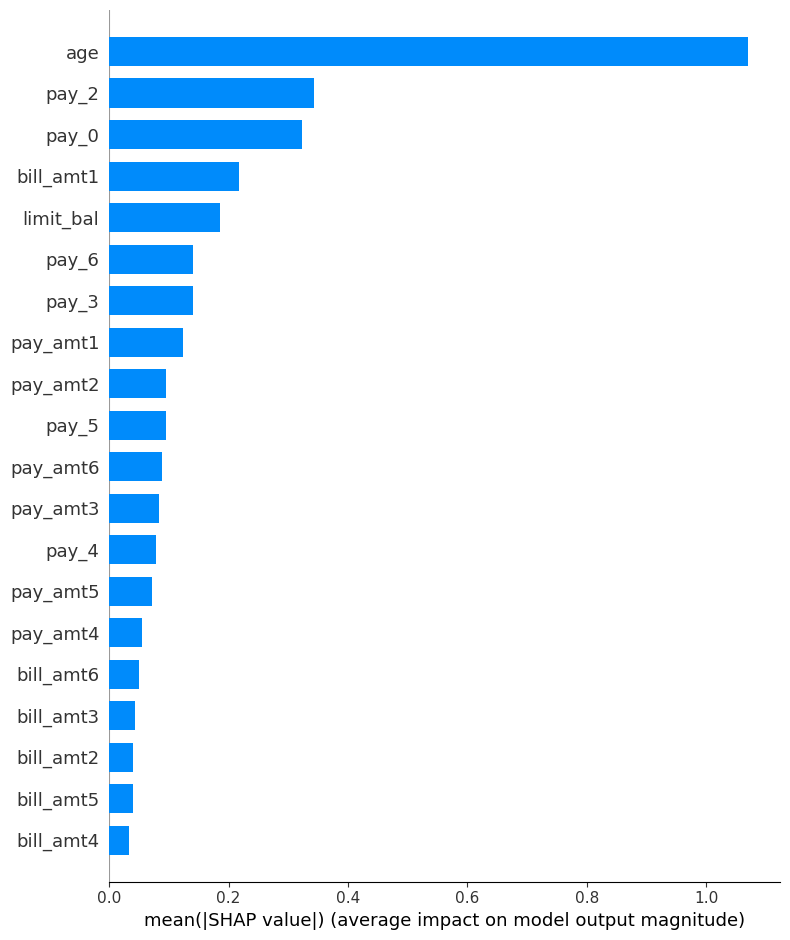

<Figure size 640x480 with 0 Axes>

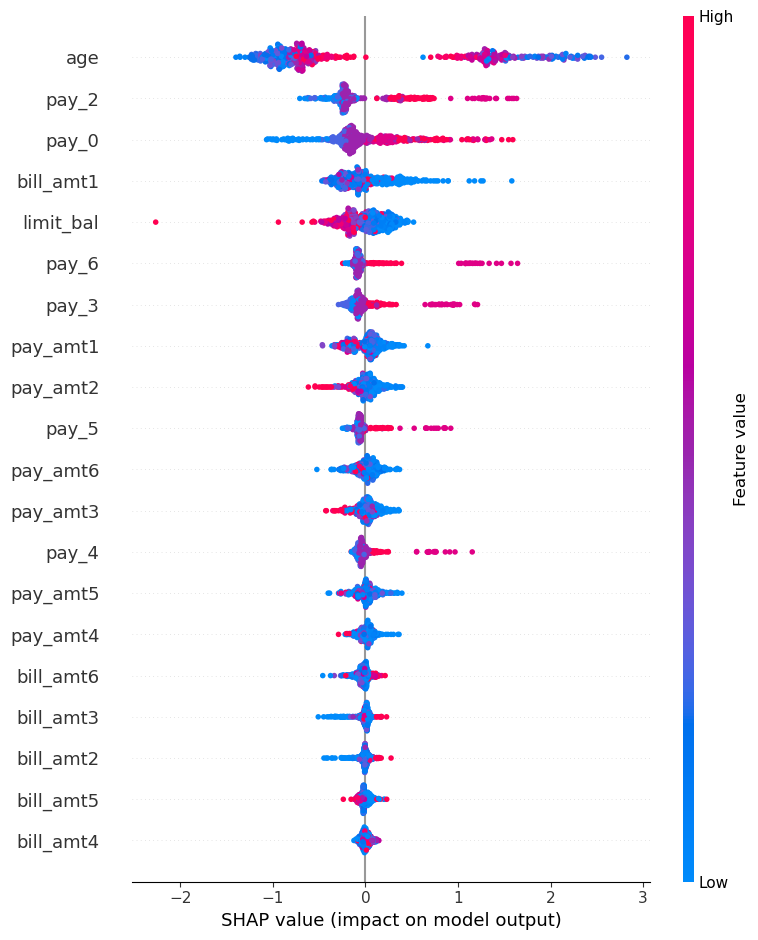

<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

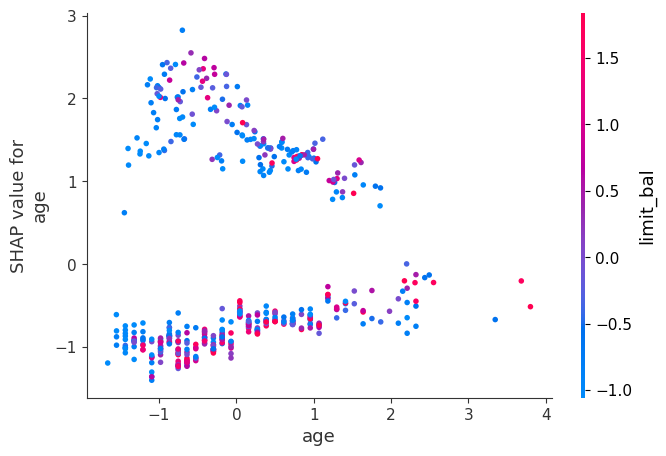

<Figure size 640x480 with 0 Axes>

In [ ]:
# Use SHAP to explain the model's predictions: plot overall feature importance, detailed distribution, and dependence of top feature

preprocessor = best_pipe.named_steps['prep']
model = best_pipe.named_steps['clf']
X_sample = X_train_smote.sample(500, random_state=47)
X_trans = preprocessor.transform(X_sample)

numeric_feats = preprocessor.transformers_[0][2]
feature_names = list(numeric_feats)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trans)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_trans, feature_names=feature_names, plot_type="bar")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_trans, feature_names=feature_names)
plt.tight_layout()
plt.show()

top_idx = np.argsort(np.abs(shap_values).mean(0))[-1]
top_feature = feature_names[top_idx]
plt.figure(figsize=(8, 5))
shap.dependence_plot(top_feature, shap_values, X_trans, feature_names=feature_names)
plt.tight_layout()
plt.show()


#### Profiling Tools


In [ ]:
import pandas as pd
import sweetviz as sv

df = pd.read_csv("train.csv")
report = sv.analyze(df)
report.show_html("Sweetviz_Profiling.html")

                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport

df = pd.read_csv("train.csv")
profile = ProfileReport(df, explorative=True)
profile.to_file("YData_Profiling.html")

print("Pandas Profiling Report generated successfully!")